# AutoML with Text data - Using AutoGluon 

Here we introduce the `TextPrediction` task, which helps you automatically train and deploy models for various Natural Language Processing (NLP) problems.
This tutorial presents two examples to quickly demonstrate how `TextPrediction` can be used for different NLP tasks including:
- [Sentiment Analysis](https://en.wikipedia.org/wiki/Sentiment_analysis)
- [Sentence Similarity](https://arxiv.org/abs/1910.03940)

The general usage is similar to AutoGluon's `TabularPrediction` module. We treat NLP datasets as tables where certain columns contain text fields and a special column contains the labels to predict. Here, the labels can be discrete categories (classification) or numerical values (regression).
`TextPrediction` fits neural networks to your data via transfer learning from pretrained NLP models like: [BERT](https://arxiv.org/pdf/1810.04805.pdf), [ALBERT](https://arxiv.org/pdf/1909.11942.pdf), and [ELECTRA](https://openreview.net/pdf?id=r1xMH1BtvB).
`TextPrediction` also trains multiple models with different hyperparameters and returns the best model, a process called Hyperparameter Optimization (HPO).

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

## Sentiment Analysis

First, we consider the Stanford Sentiment Treebank ([SST](https://nlp.stanford.edu/sentiment/)) dataset, which consists of movie reviews and their associated sentiment. Given a new movie review, the goal is to predict the sentiment reflected in the text (in this case a **binary classification** problem, where reviews are labeled as 1 if they convey a positive opinion and labeled as 0 otherwise). Let's first load the data and view some examples, noting the labels are stored in a column called **label**.

In [2]:
from autogluon.utils.tabular.utils.loaders.load_pd import load
train_data = load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/train.parquet')
dev_data = load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/dev.parquet')

rand_idx = np.random.permutation(np.arange(len(train_data)))[:2000]
train_data = train_data.iloc[rand_idx]
train_data.head(10)

Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/train.parquet | Columns = 2 / 2 | Rows = 67349 -> 67349
Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/dev.parquet | Columns = 2 / 2 | Rows = 872 -> 872


,sentence,label
2434,goes by quickly,1
27796,reading lines from a teleprompter,0
249,"degraded , handheld blair witch video-cam foot...",0
12115,reminds us how realistically nuanced a robert ...,1
50834,indulges in the worst elements of all of them .,0
43622,are nowhere near as vivid as the 19th-century ...,0
3955,throughout a film that is both gripping and co...,1
51011,to see over and over again,1
31232,that fails to match the freshness of the actre...,0
32153,this is an undeniably intriguing film from an ...,1


Above the data happen to be stored in a [Parquet](https://databricks.com/glossary/what-is-parquet) table format, but you can also directly `load()` data from a [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) file instead. While here we load files from [AWS S3 cloud storage](https://docs.aws.amazon.com/AmazonS3/latest/dev/Welcome.html), these could instead be local files on your machine. After loading, `train_data` is simply a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), where each row represents a different training example (for machine learning to be appropriate, the rows should be independent and identically distributed).

To ensure this tutorial runs quickly, we simply call `fit()` with a subset of 2000 training examples and limit its runtime to approximately 1 minute. To achieve reasonable performance in your applications, you should set much longer `time_limits` (eg. 1 hour), or do not specify `time_limits` at all.

2020-08-05 08:02:03,920 - root - INFO - All Logs will be saved to ./ag_sst/ag_text_prediction.log
2020-08-05 08:02:03,932 - root - INFO - Train Dataset:
2020-08-05 08:02:03,932 - root - INFO - Columns:

- Text(
   name="sentence"
   #total/missing=1700/0
   length, min/avg/max=4/51.83/259
)
- Categorical(
   name="label"
   #total/missing=1700/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[740, 960]
)


2020-08-05 08:02:03,933 - root - INFO - Tuning Dataset:
2020-08-05 08:02:03,933 - root - INFO - Columns:

- Text(
   name="sentence"
   #total/missing=300/0
   length, min/avg/max=5/56.73/218
)
- Categorical(
   name="label"
   #total/missing=300/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[141, 159]
)


2020-08-05 08:02:03,933 - root - INFO - Label columns=['label'], Problem types=['classification'], Label shapes=[2]
2020-08-05 08:02:03,934 - root - INFO - Eval Metric=acc, Stop Metric=acc, Log Metrics=['f1', 'mcc', 'auc', 'acc', 'nll']
2020

100%|██████████| 212/212 [00:27<00:00,  7.77it/s]


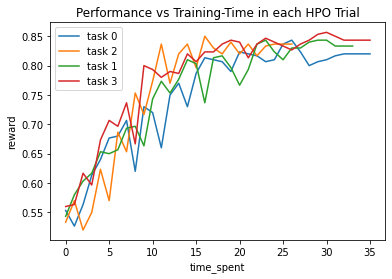

In [3]:
from autogluon import TextPrediction as task

predictor = task.fit(train_data,
                     label='label',
                     time_limits='1min',
                     ngpus_per_trial=1,
                     seed=123,
                     output_directory='./ag_sst')

Above we specify that: the **label** column of our DataFrame contains the label-values to predict, AutoGluon should run for 60 seconds, each training run of an individual model (with particular hyperparameters) should run on 1 GPU, a particular random seed should be used to facilitate reproducibility, and that trained models should be saved in the **ag_sst** folder.

Now you can use `predictor.evaluate()` to evaluate the trained model on some separate test data.

In [4]:
dev_score = predictor.evaluate(dev_data, metrics='acc')
print('Total Time = {}s'.format(predictor.results['total_time']))
print('Accuracy = {:.2f}%'.format(dev_score['acc'] * 100))

Total Time = 33.737322092056274s
Accuracy = 82.45%


And just as before, you can easily obtain predictions from these text models.

In [5]:
sentence1 = "it's a charming and often affecting journey." 
sentence2 = "It's slow, very, very, very slow."
predictions = predictor.predict({'sentence': [sentence1, sentence2]})
print('"Sentence":', sentence1, '"Sentiment":', predictions[0])
print('"Sentence":', sentence2, '"Sentiment":', predictions[1])


"Sentence": it's a charming and often affecting journey. "Sentiment": 1
"Sentence": It's slow, very, very, very slow. "Sentiment": 0


For classification tasks, you can ask for predicted class-probabilities instead of predicted classes.

In [6]:
probs = predictor.predict_proba({'sentence': [sentence1, sentence2]})
print('"Sentence":', sentence1, '"Sentiment":', probs[0])
print('"Sentence":', sentence2, '"Sentiment":', probs[1])

"Sentence": it's a charming and often affecting journey. "Sentiment": [0.00107836 0.99892163]
"Sentence": It's slow, very, very, very slow. "Sentiment": [0.73069537 0.26930466]


## Sentence Similarity

Next, let's use AutoGluon to train a model for evaluating how semantically similar two sentences are. We use the [Semantic Textual Similarity Benchmark](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) dataset for illustration. This is a regression problem.

In [7]:
train_data = load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sts/train.parquet')[['sentence1', 'sentence2', 'score']]
dev_data = load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sts/dev.parquet')[['sentence1', 'sentence2', 'score']]
train_data.head(10)

,sentence1,sentence2,score
0,A plane is taking off.,An air plane is taking off.,5.00
1,A man is playing a large flute.,A man is playing a flute.,3.80
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,Three men are playing chess.,Two men are playing chess.,2.60
4,A man is playing the cello.,A man seated is playing the cello.,4.25
5,Some men are fighting.,Two men are fighting.,4.25
6,A man is smoking.,A man is skating.,0.50
7,The man is playing the piano.,The man is playing the guitar.,1.60
8,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...,2.20
9,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.,5.00


In [8]:
print('Min score=', min(train_data['score']), ', Max score=', max(train_data['score']))

Min score= 0.0 , Max score= 5.0


In this data, the **score** column contains numerical values (which we'd like to predict) that are human-annotated similarity scores for each given pair of sentences.

Let's train a regression model to predict these scores with `task.fit()`. Note that we only need to specify the label column and AutoGluon automatically determines the type of prediction problem and an appropriate loss function. Once again, you should increase the short `time_limits` below to obtain reasonable performance in your own applications.

2020-08-05 08:12:51,632 - root - INFO - All Logs will be saved to ./ag_sts/ag_text_prediction.log
2020-08-05 08:12:51,646 - root - INFO - Train Dataset:
2020-08-05 08:12:51,647 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=4886/0
   length, min/avg/max=16/57.63/367
)
- Text(
   name="sentence2"
   #total/missing=4886/0
   length, min/avg/max=15/57.35/311
)
- Numerical(
   name="score"
   #total/missing=4886/0
   shape=()
)


2020-08-05 08:12:51,648 - root - INFO - Tuning Dataset:
2020-08-05 08:12:51,648 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=863/0
   length, min/avg/max=17/58.16/267
)
- Text(
   name="sentence2"
   #total/missing=863/0
   length, min/avg/max=16/58.55/237
)
- Numerical(
   name="score"
   #total/missing=863/0
   shape=()
)


2020-08-05 08:12:51,649 - root - INFO - Label columns=['score'], Problem types=['regression'], Label shapes=[()]
2020-08-05 08:12:51,650 - root - INFO - Eval Metric=mse, Stop Metric=mse, Log

 60%|█████▉    | 367/612 [01:02<00:41,  5.85it/s]


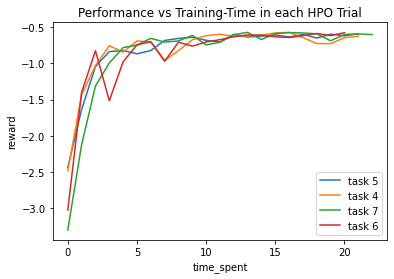

In [9]:
predictor_sts = task.fit(train_data,
                         label='score',
                         time_limits='1min',
                         ngpus_per_trial=1,
                         seed=123,
                         output_directory='./ag_sts')

We again evaluate our trained model's performance on some separate test data. Below we choose to compute the following metrics: RMSE, Pearson Correlation, and Spearman Correlation.

In [10]:
dev_score = predictor_sts.evaluate(dev_data, metrics=['rmse', 'pearsonr', 'spearmanr'])
print('Total Time = {}s'.format(predictor_sts.results['total_time']))
print('RMSE = {:.2f}'.format(dev_score['rmse']))
print('PEARSONR = {:.4f}'.format(dev_score['pearsonr']))
print('SPEARMANR = {:.4f}'.format(dev_score['spearmanr']))

Total Time = 69.68335437774658s
RMSE = 0.78
PEARSONR = 0.8566
SPEARMANR = 0.8545


Next, we use our trained model to predict the similarity score among these sentences:
- 'The child is riding a horse.'
- 'The young boy is riding a horse.'
- 'The young man is riding a horse.'
- 'The young man is riding a bicycle.'

In [11]:
sentences = ['The child is riding a horse.',
             'The young boy is riding a horse.',
             'The young man is riding a horse.',
             'The young man is riding a bicycle.']

score1 = predictor_sts.predict({'sentence1': [sentences[0]],
                                'sentence2': [sentences[1]]})

score2 = predictor_sts.predict({'sentence1': [sentences[0]],
                                'sentence2': [sentences[2]]})

score3 = predictor_sts.predict({'sentence1': [sentences[0]],
                                'sentence2': [sentences[3]]})
print(score1, score2, score3)

[3.659711] [3.009852] [1.6428676]


## Save and Load
Finally we demonstrate how to easily save and load a trained TextPrediction model.

In [12]:
predictor_sts.save('saved_dir')
predictor_sts_new = task.load('saved_dir')

score3 = predictor_sts_new.predict({'sentence1': [sentences[0]],
                                    'sentence2': [sentences[3]]})
print(score3)

[1.6428676]


## What's happening inside?

Internally, we build the network based on pretrained NLP models including [BERT](https://arxiv.org/pdf/1810.04805.pdf), [ALBERT](https://arxiv.org/pdf/1909.11942.pdf), and [ELECTRA](https://openreview.net/pdf?id=r1xMH1BtvB). The general architecture is shown as follows, in which we have a pretrained backbone model, ELECTRA-SMALL in the implementation, and some task specific layers.

<img src="images/bert.png" alt="BERT" style="width: 600px;"/>

For a more detailed explanation of pretrained language models and state-of-the-art finetuning, refer to the [D2L Book](https://d2l.ai/chapter_natural-language-processing-applications/finetuning-bert.html).

In addition to transfer learning, AutoGluon trains multiple models under different hyperparameters and finally return the best model. This hyperparameter optimization will be further explored in the next tutorial.